In [1]:
import gzip
import json
import numpy as np
from scipy.misc import logsumexp
import matplotlib.pyplot as plt

In [2]:
import os
RUN_DIR = 'runs/hawkins_big_l2_heldout_tunegrid'

In [3]:
grids_path = os.path.join(RUN_DIR, 's0_grids.0.jsons.gz')
with gzip.open(grids_path, 'rb') as infile:
    grids = [json.loads(line.strip()) for line in infile]

In [4]:
ALPHA = 0.544
BW = -0.15

In [5]:
len(grids)

3500

In [6]:
data_path = os.path.join(RUN_DIR, 'data.eval.jsons')
with open(data_path, 'r') as infile:
    insts = [json.loads(line.strip()) for line in infile]
    print(len(insts))
gold_outputs = np.array([inst['output'] for inst in insts])[:len(grids)]

3500


In [7]:
l0_biggrid = np.array([[np.array(ss['L0']).T for ss in grid['sets']] for grid in grids])

In [8]:
all_ss = l0_biggrid.shape[1]
l0_biggrid.shape

(3500, 8, 25, 3)

In [9]:
s0_biggrid = np.array([[np.array(ss['S0']).T for ss in grid['sets']] for grid in grids])

In [10]:
s0_biggrid.shape

(3500, 8, 25, 3)

In [11]:
def compute_s1(l0, alpha):
    l0_a = l0 * alpha
    return l0_a - logsumexp(l0_a, axis=2, keepdims=True)

def compute_l2(s1):
    return s1 - logsumexp(s1, axis=3, keepdims=True)

def compute_lstar(l0, l2, bw):
    unnorm = (bw * l0 + (1 - bw) * l2)[:, :, 0, :]
    return unnorm - logsumexp(unnorm, axis=2, keepdims=True)

def compute_ak(l0, s0, bw):
    unnorm = (bw * l0 + (1 - bw) * s0)[:, :, 0, :]
    return unnorm - logsumexp(unnorm, axis=2, keepdims=True)

def compute_final(lss):
    unnorm = logsumexp(lss, axis=1) - np.log(lss.shape[1])
    return unnorm - logsumexp(unnorm, axis=1, keepdims=True)

In [12]:
s1 = compute_s1(l0_biggrid, alpha=ALPHA)
l2 = compute_l2(s1)
lstar = compute_final(compute_lstar(l0_biggrid, l2, bw=BW))
ak = compute_final(compute_ak(l0_biggrid, s0_biggrid, bw=0.5))

In [13]:
def accuracy(golds, final):
    return np.sum(np.argmax(final, axis=1) == golds) * 1.0 / len(golds)

def perplexity(golds, final):
    return np.exp(-np.mean(final[np.arange(len(golds)), golds]))

In [14]:
accuracy(gold_outputs, lstar)

0.82371428571428573

In [15]:
accuracy(gold_outputs, ak)

0.83142857142857141

In [16]:
accuracy(gold_outputs, l0_biggrid[:, 0, 0, :])

0.82485714285714284

In [17]:
accuracy(gold_outputs, l2[:, 0, 0, :])

0.82399999999999995

In [18]:
accuracy(gold_outputs, s0_biggrid[:, 0, 0, :])

0.79571428571428571

In [19]:
EXA = [0.0, 2.0]
EXA.reverse()
ALPHAS = np.arange(EXA[1], EXA[0], 0.04)
EXB = [-1.0, 1.0]
BWS = np.arange(EXB[0], EXB[1], 0.04)

0 of 50
10 of 50
20 of 50
30 of 50
40 of 50
1 sample sets
best accuracy:   0.82971 at alpha=0.76000, bw=-0.36000
best perplexity: 1.53494 at alpha=0.44000, bw=0.04000


/juicer/u87/u/nlp/packages/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: divide by zero encountered in log


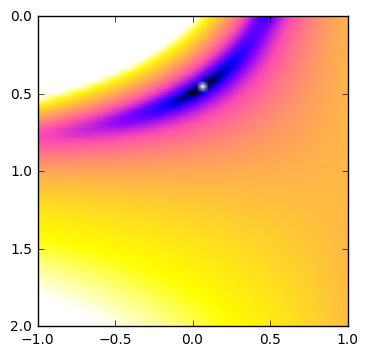

0 of 50
10 of 50
20 of 50


KeyboardInterrupt: 

In [20]:
for num_ss in range(1, l0_biggrid.shape[1] + 1):
    l0_ss = l0_biggrid[:, :num_ss, :, :]
    perps = []
    accs = []
    for i, alpha in enumerate(ALPHAS):
        if i % 10 == 0:
            print('{} of {}'.format(i, len(ALPHAS)))
        s1 = compute_s1(l0_ss, alpha)
        l2 = compute_l2(s1)
        perps_alpha = []
        accs_alpha = []
        for base_weight in BWS:
            final = compute_final(compute_lstar(l0_ss, l2, base_weight))
            perps_alpha.append(perplexity(gold_outputs, final))
            accs_alpha.append(accuracy(gold_outputs, final))
        perps.append(perps_alpha)
        accs.append(accs_alpha)

    perps_a = np.array(perps)
    perps_a[np.invert(np.isfinite(perps_a))] = 1000.0
    alpha_idx, base_idx = np.unravel_index(np.nanargmin(perps), np.array(perps).shape)
    p_coord = (ALPHAS[alpha_idx], BWS[base_idx])
    alpha_idx, base_idx = np.unravel_index(np.nanargmax(accs), np.array(accs).shape)
    a_coord = (ALPHAS[alpha_idx], BWS[base_idx])
    print('{} sample sets'.format(num_ss))
    print('best accuracy:   {:.5f} at alpha={:.5f}, bw={:.5f}'.format(np.max(accs), a_coord[0], a_coord[1]))
    print('best perplexity: {:.5f} at alpha={:.5f}, bw={:.5f}'.format(np.min(perps_a), p_coord[0], p_coord[1]))
    
    accs_limit = np.max(accs)
    perps_limit = np.min(perps_a)
    
    plt.imshow(np.log(np.minimum(perps, 3.0) - perps_limit),
               extent=EXB + EXA, aspect=1.0, cmap='gnuplot2')
    # plt.imshow(np.log(accs_limit - accs),
    #            extent=EXB + EXA, aspect=1.0, cmap='gnuplot2')
    plt.show()

In [26]:
BWS_AK = np.arange(EXB[0], EXB[1], 0.001)
l0_ss = l0_biggrid[:, :1, :, :]
s0_ss = s0_biggrid[:, :1, :, :]
perps = []
accs = []
for i, base_weight in enumerate(BWS_AK):
    if i % 100 == 0:
        print('{} of {}'.format(i, len(BWS_AK)))
    final = compute_final(compute_ak(l0_ss, s0_ss, bw=base_weight))
    perps.append(perplexity(gold_outputs, final))
    accs.append(accuracy(gold_outputs, final))

perps_a = np.array(perps)
perps_a[np.invert(np.isfinite(perps_a))] = 1000.0
alpha_idx = np.nanargmin(perps)
p_coord = BWS_AK[alpha_idx]
alpha_idx = np.nanargmax(accs)
a_coord = BWS_AK[alpha_idx]
print('{} sample sets'.format(num_ss))
print('best accuracy:   {:.5f} at bw={:.5f}'.format(np.max(accs), a_coord))
print('best perplexity: {:.5f} at bw={:.5f}'.format(np.min(perps_a), p_coord))

accs_limit = np.max(accs)
perps_limit = np.min(perps_a)

0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
2 sample sets
best accuracy:   0.83457 at bw=0.44000
best perplexity: 1.52092 at bw=0.39200


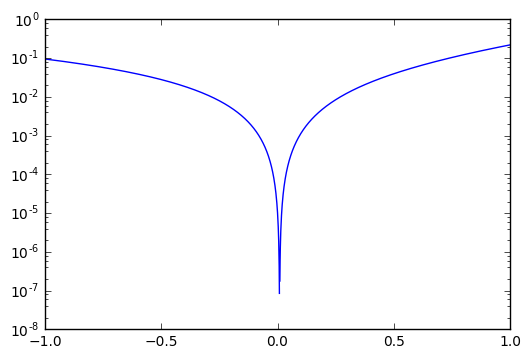

In [92]:
plt.semilogy(BWS_AK, np.minimum(perps, 3.0) - perps_limit)
plt.xlim(EXB)
plt.show()

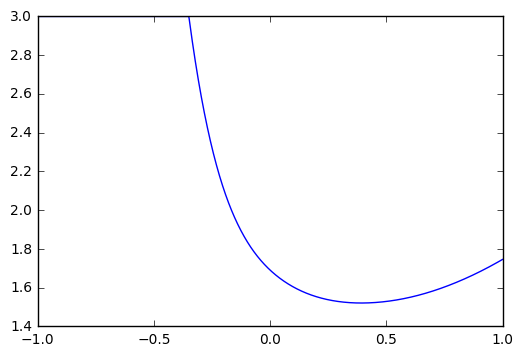

In [28]:
plt.plot(BWS_AK, np.minimum(perps, 3.0))
plt.xlim(EXB)
plt.show()

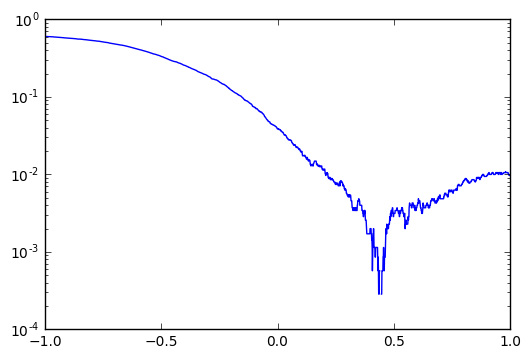

In [29]:
plt.semilogy(BWS_AK, accs_limit - accs)
plt.xlim(EXB)
plt.show()

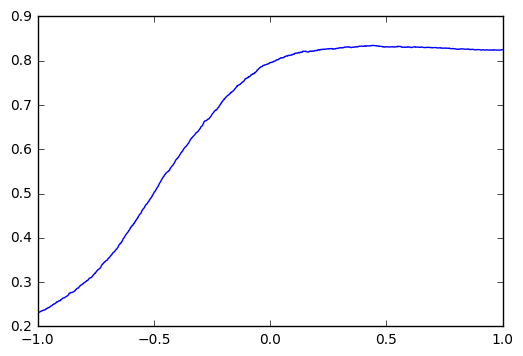

In [30]:
plt.plot(BWS_AK, accs)
plt.xlim(EXB)
plt.show()

In [32]:
bw_idx = np.nanargmin(perps)
bw_p = BWS_AK[bw_idx]
print bw_p, perps[bw_idx], accs[bw_idx]

0.392 1.52091571722 0.832857142857


In [94]:
def compute_marg(l0, s0, bw):
    s0 = s0[:, :, 0, :]
    l0 = l0[:, :, 0, :]
    l1 = s0 - logsumexp(s0, axis=2, keepdims=True)
    weighted = np.array([np.log(bw) + l0, np.log(1 - bw) + l1])
    unnorm = logsumexp(weighted, axis=0)
    return unnorm - logsumexp(unnorm, axis=2, keepdims=True)

BWS_MARG = np.arange(EXB[0], EXB[1], 0.001)
l0_ss = l0_biggrid[:, :1, :, :]
s0_ss = s0_biggrid[:, :1, :, :]
perps = []
accs = []
for i, base_weight in enumerate(BWS_MARG):
    if i % 100 == 0:
        print('{} of {}'.format(i, len(BWS_MARG)))
    final = compute_final(compute_marg(l0_ss, s0_ss, bw=base_weight))
    perps.append(perplexity(gold_outputs, final))
    accs.append(accuracy(gold_outputs, final))

perps_a = np.array(perps)
perps_a[np.invert(np.isfinite(perps_a))] = 1000.0
alpha_idx = np.nanargmin(perps)
p_coord = BWS_MARG[alpha_idx]
alpha_idx = np.nanargmax(accs)
a_coord = BWS_MARG[alpha_idx]
print('{} sample sets'.format(num_ss))
print('best accuracy:   {:.5f} at bw={:.5f}'.format(np.max(accs), a_coord))
print('best perplexity: {:.5f} at bw={:.5f}'.format(np.min(perps_a), p_coord))

accs_limit = np.max(accs)
perps_limit = np.min(perps_a)

0 of 2000


/juicer/u87/u/nlp/packages/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
4 sample sets
best accuracy:   0.82943 at bw=0.49800
best perplexity: 1.50129 at bw=0.59500


/u/nlp/packages/anaconda2/lib/python2.7/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


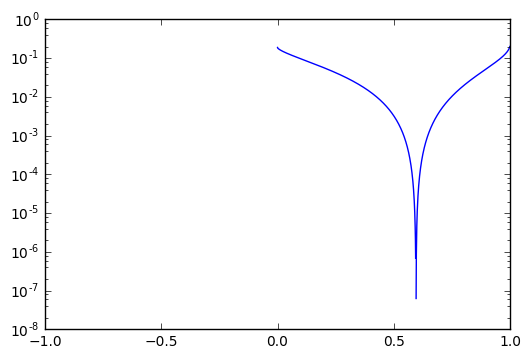

In [95]:
plt.semilogy(BWS_AK, np.minimum(perps, 3.0) - perps_limit)
plt.xlim(EXB)
plt.show()

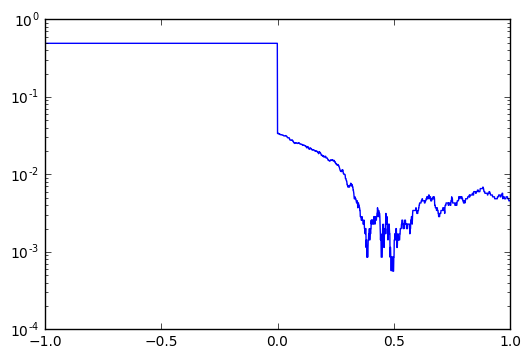

In [98]:
plt.semilogy(BWS_AK, accs_limit - accs)
plt.xlim(EXB)
plt.show()

In [66]:
ALPHAS_L1 = np.arange(EXA[1], EXA[0], 0.001)

def compute_l1(s0):
    return s0 - logsumexp(s0, axis=2, keepdims=True)

0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
4 sample sets
best accuracy:   0.79571 at alpha=0.00100
best perplexity: 1.65564 at alpha=0.72000


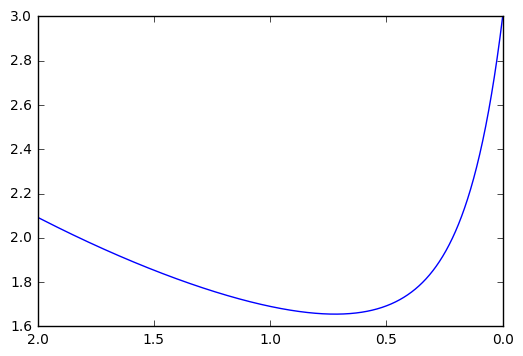

In [67]:
s0_ss = s0_biggrid[:, :1, 0, :]
perps = []
accs = []
for i, alpha in enumerate(ALPHAS_L1):
    if i % 100 == 0:
        print('{} of {}'.format(i, len(ALPHAS_L1)))
    l1 = compute_l1(s0_ss * alpha)
    final = compute_final(l1)
    perps.append(perplexity(gold_outputs, final))
    accs.append(accuracy(gold_outputs, final))

perps_a = np.array(perps)
perps_a[np.invert(np.isfinite(perps_a))] = 1000.0
p_idx = np.nanargmin(perps)
p_alpha = ALPHAS_L1[p_idx]
a_idx = np.nanargmax(accs)
a_alpha = ALPHAS_L1[a_idx]
print('{} sample sets'.format(num_ss))
print('best accuracy:   {:.5f} at alpha={:.5f}'.format(np.max(accs), a_alpha))
print('best perplexity: {:.5f} at alpha={:.5f}'.format(np.min(perps_a), p_alpha))

accs_limit = np.max(accs)
perps_limit = np.min(perps_a)

#plt.plot(ALPHAS_L1, np.minimum(perps, 3.0) - perps_limit)
plt.plot(ALPHAS_L1, perps)
plt.xlim(EXA)
plt.show()

In [68]:
accs[p_idx]

0.79571428571428571

In [85]:
s1 = compute_s1(l0_biggrid, alpha=ALPHA)
l2 = compute_l2(s1)
lstar = compute_final(compute_lstar(l0_biggrid, l2, bw=BW))
ak = compute_final(compute_ak(l0_biggrid, s0_biggrid, bw=0.392))

In [81]:
perplexity(gold_outputs, lstar)

1.5325473424427118

In [82]:
perplexity(gold_outputs, l0_biggrid[:, 0, 0, :])

1.7464103511524245

In [83]:
perplexity(gold_outputs, l2[:, 0, 0, :])

1.5409137324220705

In [86]:
perplexity(gold_outputs, ak)

1.520915717220384

0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
4 sample sets
best accuracy:   0.83486 at gamma=0.19200
best perplexity: 1.49288 at gamma=0.50900


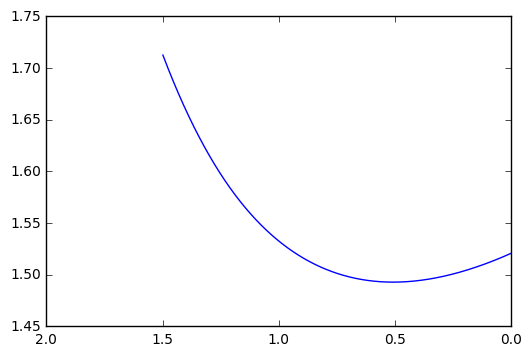

In [88]:
GAMMAS = np.arange(-0.5, 1.5, 0.001)

def blend_final(a, b, gamma):
    unnorm = (1 - gamma) * a + gamma * b
    return unnorm - logsumexp(unnorm, axis=1, keepdims=True)

perps = []
accs = []
for i, gamma in enumerate(GAMMAS):
    if i % 100 == 0:
        print('{} of {}'.format(i, len(GAMMAS)))
    final = blend_final(ak, lstar, gamma)
    perps.append(perplexity(gold_outputs, final))
    accs.append(accuracy(gold_outputs, final))

perps_a = np.array(perps)
perps_a[np.invert(np.isfinite(perps_a))] = 1000.0
p_idx = np.nanargmin(perps)
p_alpha = GAMMAS[p_idx]
a_idx = np.nanargmax(accs)
a_alpha = GAMMAS[a_idx]
print('{} sample sets'.format(num_ss))
print('best accuracy:   {:.5f} at gamma={:.5f}'.format(np.max(accs), a_alpha))
print('best perplexity: {:.5f} at gamma={:.5f}'.format(np.min(perps_a), p_alpha))

accs_limit = np.max(accs)
perps_limit = np.min(perps_a)

#plt.plot(ALPHAS_L1, np.minimum(perps, 3.0) - perps_limit)
plt.plot(GAMMAS, perps)
plt.xlim([-0.5, 1.5])
plt.show()

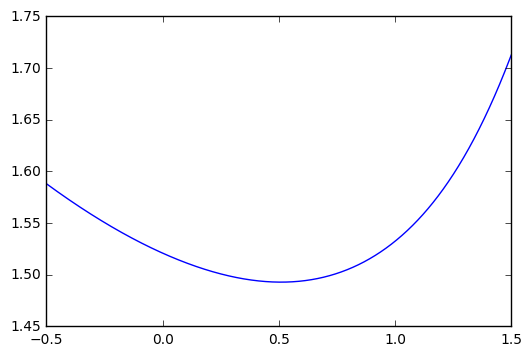

In [90]:
plt.plot(GAMMAS, perps)
plt.xlim([-0.5, 1.5])
plt.show()

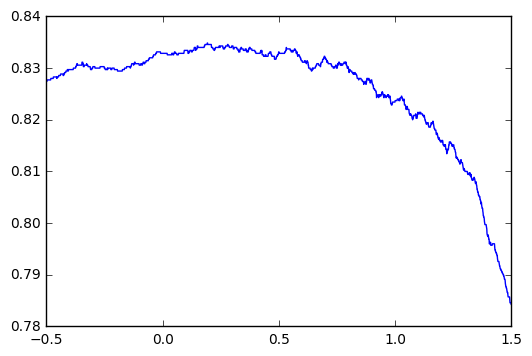

In [91]:
plt.plot(GAMMAS, accs)
plt.xlim([-0.5, 1.5])
plt.show()

In [124]:
def log_weighted_ave(arrs, weights):
    arrs = np.array(arrs)
    log_weights = np.log(weights)
    log_weights -= logsumexp(log_weights)
    for _ in range(len(arrs.shape) - 1):
        log_weights = log_weights[..., np.newaxis]
    return logsumexp(arrs + log_weights, axis=0)


def fullblend_perp(args):
    alpha_l, alpha_s, l0w, l1w, l2w = args

    l0 = l0_biggrid[:, 0, 0, :]

    l1 = compute_final(compute_l1(s0_biggrid[:, :1, 0, :] * alpha_s))

    s1 = compute_s1(l0_biggrid, alpha=alpha_l)
    l2 = compute_final(compute_l2(s1)[:, :, 0, :])
    
    lstar = log_weighted_ave([l0, l1, l2], [l0w, l1w, l2w])
    
    perp = perplexity(gold_outputs, lstar)

    cap = 3.0 + np.sum(args ** 2)
    if np.isfinite(perp):
        return min(perp, cap)
    else:
        return cap


fullblend_perp(np.array([0, 0, 0, 0, 0]))

/juicer/u87/u/nlp/packages/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/juicer/u87/u/nlp/packages/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in subtract


3.0

In [125]:
from scipy.optimize import minimize
res = minimize(fullblend_perp,
               x0=[0.544, 0.720, 1/3., 1/3., 1/3.],
               method='Powell')

/juicer/u87/u/nlp/packages/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


In [126]:
res

   direc: array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [-0.00126419,  0.04759769, -0.02169931, -0.00622933,  0.00408287]])
     fun: 1.4825083018667993
 message: 'Optimization terminated successfully.'
    nfev: 279
     nit: 4
  status: 0
 success: True
       x: array([ 0.55483386,  1.2925486 ,  0.07963626,  0.23867983,  0.48568906])

In [132]:
w = np.array([0.07963626,  0.23867983,  0.48568906])
w /= np.sum(w)
w.tolist()

[0.09904944016838697, 0.29686355864760317, 0.6040870011840098]

In [131]:
fullblend_perp(np.array(res.x[:2].tolist() + w.tolist()))

1.482508301871162

In [133]:
fullblend_perp(np.array([0.555, 1.293, 0.099, 0.297, 0.604]))

1.482508085214596

In [135]:
0.099 + 0.297 + 0.604

1.0

In [ ]:
arrs = np.array(arrs)
log_weights = np.log(weights)
log_weights -= logsumexp(log_weights)
for _ in range(len(arrs.shape) - 1):
    log_weights = log_weights[..., np.newaxis]
return logsumexp(arrs + log_weights, axis=0)

/juicer/u87/u/nlp/packages/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


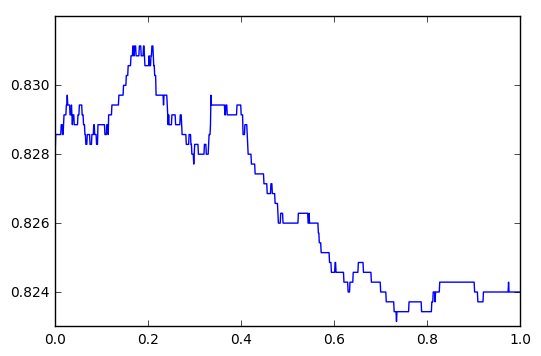

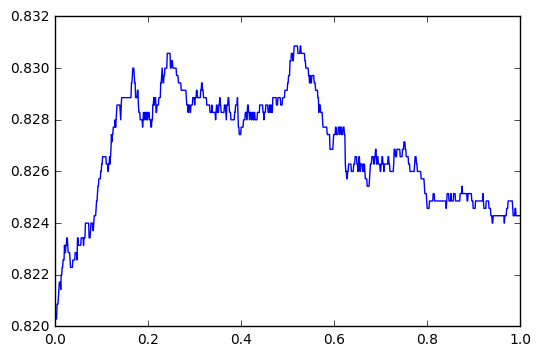

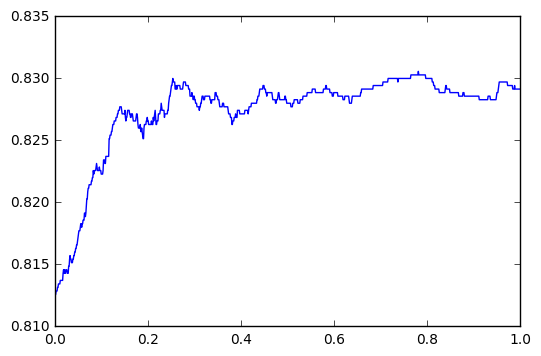

In [145]:
def fullblend_acc_funcs(args):
    alpha_l, alpha_s, l0w, l1w, l2w = args

    l0 = l0_biggrid[:, 0, 0, :]

    l1 = compute_final(compute_l1(s0_biggrid[:, :1, 0, :] * alpha_s))

    s1 = compute_s1(l0_biggrid, alpha=alpha_l)
    l2 = compute_final(compute_l2(s1)[:, :, 0, :])

    def acc_by_l0w(new_l0w):
        lstar = log_weighted_ave([l0, l1, l2], [new_l0w, l1w, l2w])
        return accuracy(gold_outputs, lstar)

    def acc_by_l1w(new_l1w):
        lstar = log_weighted_ave([l0, l1, l2], [l0w, new_l1w, l2w])
        return accuracy(gold_outputs, lstar)

    def acc_by_l2w(new_l2w):
        lstar = log_weighted_ave([l0, l1, l2], [l0w, l1w, new_l2w])
        return accuracy(gold_outputs, lstar)
    
    return acc_by_l0w, acc_by_l1w, acc_by_l2w


WTS = np.arange(0., 1., 0.001)

for pfunc in fullblend_acc_funcs(np.array([0.555, 1.293, 0.099, 0.297, 0.604])):
    plt.plot(WTS, [pfunc(w) for w in WTS])
    plt.xlim([0.0, 1.0])
    plt.show()

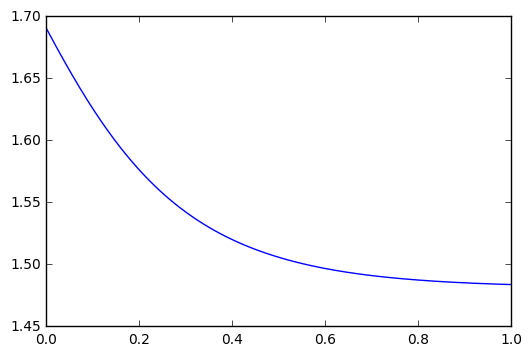

In [142]:
def fullblend_perp_as_func(args):
    alpha_l, alpha_s, l0w, l1w, l2w = args

    l0 = l0_biggrid[:, 0, 0, :]

    s1 = compute_s1(l0_biggrid, alpha=alpha_l)
    l2 = compute_final(compute_l2(s1)[:, :, 0, :])

    cap = 3.0 + np.sum(args ** 2)
    def cap_perp(perp):
        if np.isfinite(perp):
            return min(perp, cap)
        else:
            return cap
        
    def perp_by_as(new_as):
        l1 = compute_final(compute_l1(s0_biggrid[:, :1, 0, :] * new_as))

        lstar = log_weighted_ave([l0, l1, l2], [l0w, l1w, l2w])
        return cap_perp(perplexity(gold_outputs, lstar))
    
    return perp_by_as


AS = np.arange(0., 3., 0.001)
pas = fullblend_perp_as_func(np.array([0.555, 1.293, 0.099, 0.297, 0.604]))
plt.plot(AS, [pas(w) for w in AS])
plt.xlim([0.0, 3.0])
plt.show()

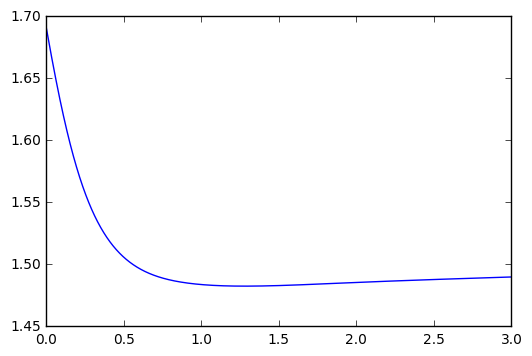

In [158]:
def normalize(arr, axis=1):
    return arr - logsumexp(arr, axis=axis, keepdims=True)


def weighted_ave(arrs, weights):
    arrs = np.array(arrs)
    weights = np.array(weights)
    for _ in range(len(arrs.shape) - 1):
        weights = weights[..., np.newaxis]
    return normalize(np.sum(arrs * weights, axis=0))


def multiplicative_perp(args):
    alpha_l, alpha_s, l0w, l1w, l2w = args

    l0 = l0_biggrid[:, 0, 0, :]

    l1 = compute_final(compute_l1(s0_biggrid[:, :1, 0, :] * alpha_s))

    s1 = compute_s1(l0_biggrid, alpha=alpha_l)
    l2 = compute_final(compute_l2(s1)[:, :, 0, :])

    lstar = weighted_ave([l0, l1, l2], [l0w, l1w, l2w])

    perp = perplexity(gold_outputs, lstar)

    cap = 3.0 + np.sum(args ** 2)
    if np.isfinite(perp):
        return min(perp, cap)
    else:
        return cap


multiplicative_perp(np.array([1., 1., 1/3., 1/3., 1/3.]))

1.5597041099869022

In [160]:
res = minimize(multiplicative_perp,
               x0=[1.0, 1.0, 1/3., 1/3., 1/3.],
               method='Powell')
res

   direc: array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [-0.00629851,  0.04030122,  0.02444815, -0.01406224,  0.10891229]])
     fun: 1.4839782997913915
 message: 'Optimization terminated successfully.'
    nfev: 189
     nit: 3
  status: 0
 success: True
       x: array([-0.10302636,  1.12399712,  0.39776836,  0.29599891,  0.6441925 ])